In [2]:
#-----packages
from sklearn.datasets import make_moons
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
from sklearn.model_selection import train_test_split

In [155]:
#-----import the moon data
X, y_test = make_moons(n_samples=300, noise=0.2)
#-----split the test & train set (ratio: 2:8)
x_train, x_valid, y_train, y_valid = train_test_split(X, y_test, test_size=0.2, shuffle=True, stratify=y_test, random_state=34)

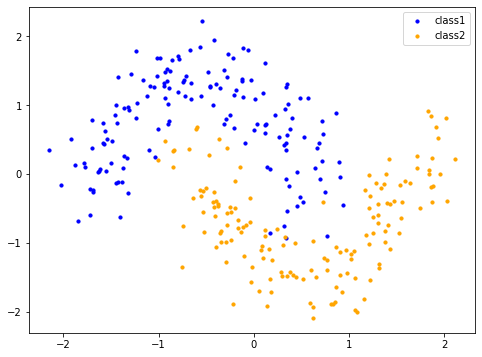

In [346]:
#-----visualize the original dataset
fig = plt.figure(figsize=(8,6))
mask = y_test == 0
plt.scatter(X[:, 0][mask], X[:, 1][mask], c='blue', s=10, label='class1')
plt.scatter(X[:, 0][~mask], X[:, 1][~mask], c='orange', s=10, label='class2')
plt.legend()
plt.show()

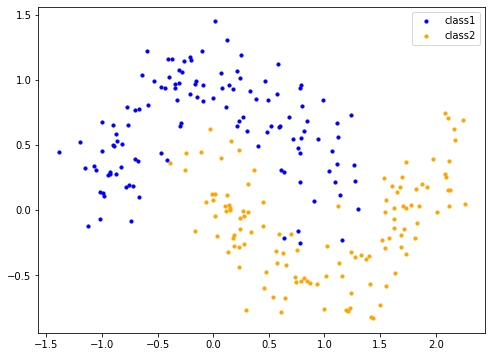

In [156]:
#-----visualize the original dataset
fig = plt.figure(figsize=(8,6))
mask = y_train == 0
plt.scatter(x_train[:, 0][mask], x_train[:, 1][mask], c='blue', s=10, label='class1')
plt.scatter(x_train[:, 0][~mask], x_train[:, 1][~mask], c='orange', s=10, label='class2')
plt.legend()
plt.show()

In [157]:
#-----divide class1(0)
sample0 = x_train[:][mask]
sample1 = x_train[:][~mask]

In [158]:
#-----get the mean vector & covariance matrix of each data
mu0 = np.mean(sample0, axis=0)
mu1 = np.mean(sample1, axis=0)
cov0 = np.atleast_2d(np.cov(sample0.T))
cov1 = np.atleast_2d(np.cov(sample1.T))

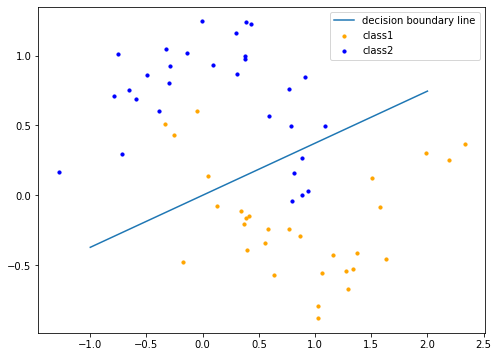

number of c1 that are classified as c2:  4
number of c2 that are classified as c1:  5
total accuracy 0.85


In [160]:
####(1) Finsher Discriminant Analysis ####
#-----S_within
s_within = cov0 + cov1
inv_s_within = np.linalg.inv(s_within)
#-----S_between and weight vector
b = mu1 - mu0
w = np.dot(inv_s_within, b.T)
d_0 = -w[0]/w[1]
w_0 = w[1]/w[0]
#-----Draw decision boundary line and weight vector 
x = [-1, 0, 2]
x2 = [-0.3, 0, 0.3]
y = [(d_0*n) for n in x]
y2 = [(w_0*n) for n in x2]
fig = plt.figure(figsize=(8,6))
#-----Visualization
mask = y_valid == 1
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')
result0 = x_valid[:][mask]
result1 = x_valid[:][~mask]
plt.plot(x,y, label='decision boundary line')
plt.legend()
plt.show()
#-----Check accuracy (Fisher)
false_c1 = 0
false_c2 = 0
for i in range(len(result0)):
    if result0[i][1] > d_0*result0[i][0]:
        false_c1 += 1
for i in range(len(result1)):
    if result1[i][1] < d_0*result1[i][0]:
        false_c2 += 1
print("number of c1 that are classified as c2: ", false_c1)
print("number of c2 that are classified as c1: ", false_c2)
print("total accuracy", 1-(false_c1+false_c2)/len(x_valid))

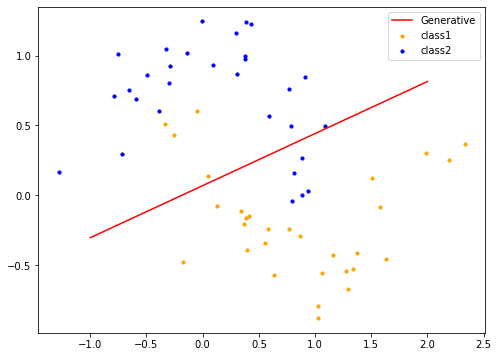

number of c1 that are classified as c2:  4
number of c2 that are classified as c1:  5
total accuracy 0.85


In [290]:
####(2) Generative (with Gaussian assumption) ####
#-----calculate a common covariance matrix
N = len(sample0) + len(sample0)
common_cov = (len(sample0)/N)*cov0 + (len(sample1)/N)*cov1
#-----weight vector and bias
inv_cov = np.linalg.inv(common_cov)
w_gen = np.dot(inv_cov, mu1 - mu0)
w0_gen = (-1/2) * np.dot(np.dot(mu0.T, inv_cov) , mu0.T) +  (1/2) * np.dot(np.dot(mu1.T, inv_cov) , mu1.T) + math.log(len(sample0)/len(sample1))
#-----calculate a gradient and an intercept
w_g = -w_gen[0]/w_gen[1]
w0_g = -w0_gen/w_gen[1]
#-----Visualization
x = [-1, 0, 2]
x_gen = [(n * w_g - w0_g) for n in x]
fig = plt.figure(figsize=(8,6))
mask = y_valid == 1
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')

result0 = x_valid[:][mask]
result1 = x_valid[:][~mask]

plt.plot(x,x_gen, c='red', label='Generative')
plt.plot(x,y, label='Fisher')
plt.legend()
plt.show()
#-----Check accuracy (Generative)
false_c1 = 0
false_c2 = 0
for i in range(len(result0)):
    if result0[i][1] > result0[i][0]* w_g - w0_g:
        false_c1 += 1
for i in range(len(result1)):
    if result1[i][1] < result1[i][0]* w_g - w0_g:
        false_c2 += 1
print("number of c1 that are classified as c2: ", false_c1)
print("number of c2 that are classified as c1: ", false_c2)
print("total accuracy", 1-(false_c1+false_c2)/len(x_valid))

In [10]:
####(3) Logistic regression ####
def y_n(w, x):
    a = np.dot(w, x).astype("float_") 
    return 1.0 / (1.0 + np.exp(-a))
def NR_update(Pi, t):
    #initialization
    w_old, w_new = np.zeros(len(Pi[1])), np.zeros(len(Pi[1]))
    N = len(Pi)
    R = [[0] * N for _ in range(N)]
    i = 0
    while i < 100:
        #-----predictition (y_n)
        pred = []
        for i in range(N):
            pred.append(y_n(w_old, Pi[i]))
        pred = np.array(pred, np.float)     
        #-----a derivative of E(w)
        E = np.dot(Pi.T, pred-t)
        #-----R matrix
        for i in range(N):
            for j in range(N):
                if i == j:
                    R[i][j] = pred[i] * (1 - pred[i])
        R = np.array(R, np.float)
        
        #-----inverse of Hessian matrix
        H = np.dot(np.dot(Pi.T, R), Pi)
        d = np.linalg.det(H)
        H_inv = np.linalg.inv(H)
        #-----Newton-Raphson update
        w_new = w_old - np.dot(H_inv, E)
        if np.abs(w_new[0] - w_old[0]) > 0.0000001:
            w_old = w_new
        else:
            break
        i += 1
    return w_new

In [11]:
#-----weight vector and bias
Pi = []
for i in range(len(x_train)):
    Pi.append([x_train[i][0], x_train[i][1], 1])
Pi = np.array(Pi)
w1, w2, w3 = NR_update(Pi, y_train)[0], NR_update(Pi, y_train)[1], NR_update(Pi, y_train)[2]
lo = -(w1/w2)
lo_0 = w3/w2

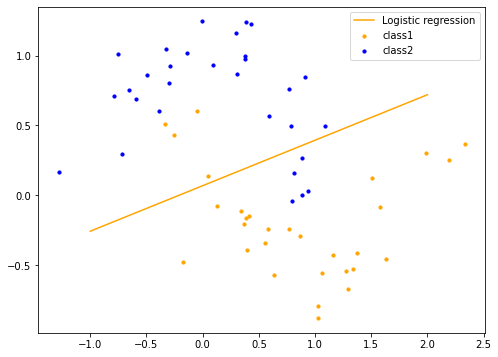

number of c1 that are classified as c2:  4
number of c2 that are classified as c1:  5
total accuracy 0.85


In [293]:
#-----visualization
x = [-1, 0, 2]
x_lo = [(n * lo - lo_0) for n in x]
fig = plt.figure(figsize=(8,6))
mask = y_valid == 1
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')
result0 = x_valid[:][mask]
result1 = x_valid[:][~mask]
#plt.plot(x,x_gen, c='red', label='Generative')
#plt.plot(x,y, label='Fisher')
plt.plot(x,x_lo, c='orange', label='Logistic regression')
plt.legend()
plt.show()
#-----Check accuracy (Logistic regression)
false_c1 = 0
false_c2 = 0
for i in range(len(result0)):
    if result0[i][1] > result0[i][0]* lo - lo_0:
        false_c1 += 1
for i in range(len(result1)):
    if result1[i][1] < result1[i][0]* lo - lo_0:
        false_c2 += 1
print("number of c1 that are classified as c2: ", false_c1)
print("number of c2 that are classified as c1: ", false_c2)
print("total accuracy", 1-(false_c1+false_c2)/len(x_valid))

In [195]:
####(5) Gaussian Process ####
#-----Gaussian kernel function
def g_kernel(X1, X2, sigma=1):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2*(X1@X2.T)
    return np.exp(-1*sqdist/(2*sigma)**2)

In [287]:
#-----Calculate prediction
C_n = g_kernel(x_train, x_train, 0.015)
y_pred = g_kernel(x_train, x_valid, 0.015).T@np.linalg.inv(C_n)@y_train
#-----sigmoid function
temp = 1/(1+np.exp(-y_pred))
temp[temp<=0.5] = 0
temp[temp>0.5] = 1

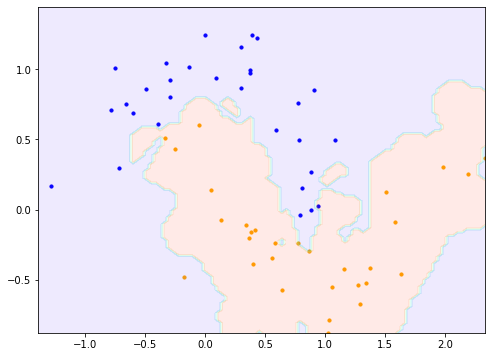

accuarcy is  0.9333333333333333


In [288]:
#-----visualization
grid_size = 100
A, B = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))
back = np.hstack([A.reshape(-1, 1), B.reshape(-1, 1)])
C_pred = g_kernel(x_train, back, 0.015).T@a
gridtemp = 1/(1+np.exp(-C_pred))
gridtemp[gridtemp<=0.5] = 0
gridtemp[gridtemp>0.5] = 1
C = gridtemp.reshape(grid_size, grid_size)
fig = plt.figure(figsize=(8,6))
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')
plt.contourf(A, B, C, alpha=0.1, cmap=plt.cm.rainbow)
plt.show()
#-----accuracy
unique, counts = np.unique((temp == y_valid), return_counts=True)
acc = dict(zip(unique, counts))[1]/len(temp)
print("accuarcy is ", acc)

In [262]:
####(6) k-means clustering ####
#-----number of clusters
K = 4
#-----initialize centers 
center = np.zeros((K,2))
for i in range(K):
    center[i] = np.random.rand(2)

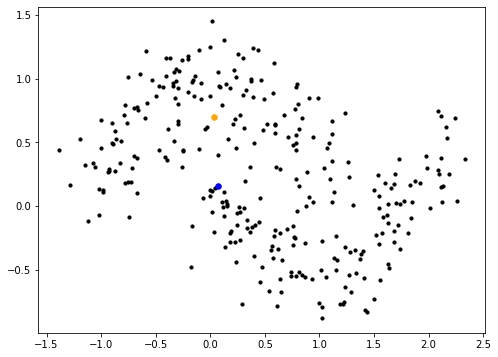

In [263]:
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c='black',s=10)
plt.scatter(center[0][0], center[0][1], c='blue',s=30)
plt.scatter(center[1][0], center[1][1], c='orange',s=30)
plt.show()

In [264]:
center

array([[0.07017415, 0.15665112],
       [0.03442   , 0.7007826 ],
       [0.03813186, 0.34413132],
       [0.29871414, 0.82426033]])

In [268]:
#-----EM algorithm
temp_c = np.zeros(len(X))
array1, array2, array3, array4 = [], [], [],[]
while True:
    #calculate distances of each point to each mean
    for j in range(len(X)):
        tempDist = np.zeros(K)
        for i in range(K):
            tempDist[i] = (center[i] - X[j])@(center[i] - X[j])
        temp_c[j] = np.where(min(tempDist) == tempDist)[0][0]
        if temp_c[j] == 0:
            array1.append(X[j])
        elif temp_c[j] == 1:
            array2.append(X[j])
        elif temp_c[j] == 2:
            array3.append(X[j])
        else:
            array4.append(X[j])
    #update the means
    c_old = center
    center = np.array([np.mean(array1, axis=0), np.mean(array2, axis=0), np.mean(array3, axis=0), np.mean(array4, axis=0)])
    #stop the loop when there's no change of the mean
    if (c_old[0] - np.mean(array1, axis=0))@(c_old[0] - np.mean(array1, axis=0)) < 0.00001:
        break
array1, array2, array3, array4 = np.array(array1), np.array(array2),np.array(array3), np.array(array4)

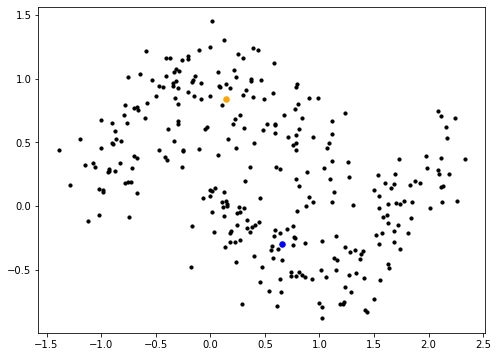

In [269]:
#-----visualize optimized centers of each cluster
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c='black',s=10)
plt.scatter(center[0][0], center[0][1], c='blue',s=30)
plt.scatter(center[1][0], center[1][1], c='orange',s=30)
plt.show()

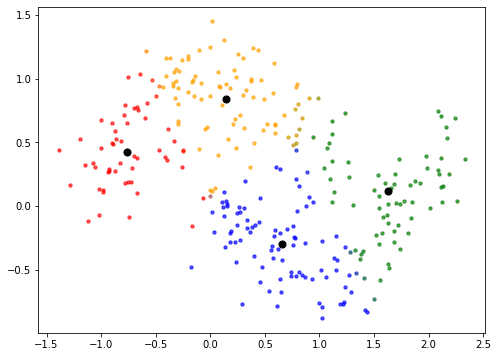

In [282]:
#-----Visualization
fig = plt.figure(figsize=(8,6))
plt.scatter(array1[:,0], array1[:,1], c='blue', alpha=0.1, marker='o',  s=10)
plt.scatter(array2[:,0], array2[:,1], c='orange', alpha=0.1,marker='o',  s=10)
plt.scatter(array3[:,0], array3[:,1], c='red', alpha=0.1,marker='o',  s=10)
plt.scatter(array4[:,0], array4[:,1], c='green', alpha=0.1,marker='o',  s=10)
plt.scatter(center[0][0], center[0][1], c='black',marker='o',s=50)
plt.scatter(center[1][0], center[1][1], c='black',marker='o',s=50)
plt.scatter(center[2][0], center[2][1], c='black',marker='o',s=50)
plt.scatter(center[3][0], center[3][1], c='black',marker='o',s=50)
plt.show()

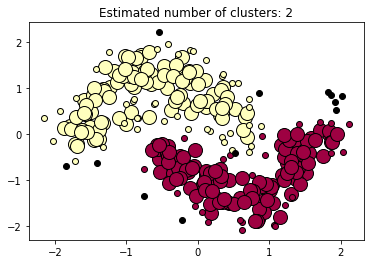

In [344]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
# Compute DBSCAN
db = DBSCAN(eps=0.365, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

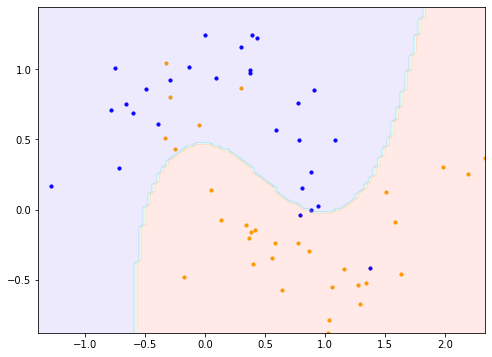

Accuracy: 0.9333333333333333


In [279]:
#-----SVM with rbf kernel
from sklearn.svm import SVC
from sklearn import metrics
clf = SVC(kernel='rbf')
clf.fit(x_train, y_train)
#-----visualization
grid_size = 100
A, B = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))
C = clf.predict( np.hstack([A.reshape(-1, 1), B.reshape(-1, 1)]) ).reshape(grid_size, grid_size)
fig = plt.figure(figsize=(8,6))
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')
plt.contourf(A, B, C, alpha=0.1, cmap=plt.cm.rainbow)
plt.show()
#-----accuracy
y_pred = clf.predict(x_valid)
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

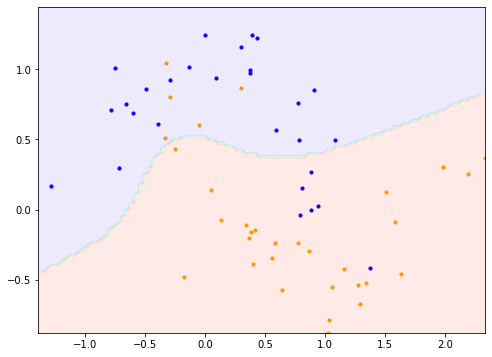

Accuracy: 0.8833333333333333


In [231]:
#-----SVM with polynomial kernel
clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
#-----visualization
grid_size = 100
A, B = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))
C = clf.predict( np.hstack([A.reshape(-1, 1), B.reshape(-1, 1)]) ).reshape(grid_size, grid_size)
fig = plt.figure(figsize=(8,6))
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')
plt.contourf(A, B, C, alpha=0.1, cmap=plt.cm.rainbow)
plt.show()
#-----accuracy
y_pred = clf.predict(x_valid)
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

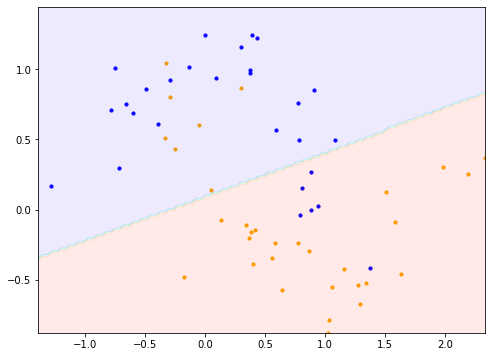

Accuracy: 0.85


In [232]:
#-----SVM with linear kernel
clf = SVC(kernel='linear')
clf.fit(x_train, y_train)
#-----visualization
grid_size = 100
A, B = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))
C = clf.predict( np.hstack([A.reshape(-1, 1), B.reshape(-1, 1)]) ).reshape(grid_size, grid_size)
fig = plt.figure(figsize=(8,6))
plt.scatter(x_valid[:, 0][mask], x_valid[:, 1][mask], c='orange', s=10, label='class1')
plt.scatter(x_valid[:, 0][~mask], x_valid[:, 1][~mask], c='blue', s=10, label='class2')
plt.contourf(A, B, C, alpha=0.1, cmap=plt.cm.rainbow)
plt.show()
#-----accuracy
y_pred = clf.predict(x_valid)
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))